In [1]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv

from citylearn.citylearn import CityLearnEnv
from citylearn.wrappers import NormalizedObservationWrapper, StableBaselines3Wrapper, DiscreteActionWrapper
from citylearn.data import DataSet

from art.estimators.classification import PyTorchClassifier as classifier
from art.attacks.evasion import AutoConjugateGradient as ACG

from torch.nn import CrossEntropyLoss

from tqdm import tqdm

import pandas as pd
import numpy as np

In [2]:
%matplotlib inline

todo: add test env (new seed?)

In [3]:
dataset_name = 'citylearn_challenge_2022_phase_2' #only action is electrical storage

In [4]:
schema = DataSet.get_schema(dataset_name)

In [5]:
def make_discrete_env(schema, action_bins: int = 10, bldg: list = ['Building_1'], single_agent: bool = True, seed:int = 0):
    """Because ART's attacks are designed for supervised learning they one work with ANNs with a single label or head, using multiple buildings adds an action/head for each"""
    env = CityLearnEnv(schema, 
        central_agent=single_agent, 
        buildings=bldg, 
        random_seed=seed)
    #Because ART attacks are made for classification tasks we need a discrete action space 
    env = DiscreteActionWrapper(env, bin_sizes=[{'electrical_storage':action_bins}])
    #Calendar observations are periodically normalized, everything else is min/max normalized 
    env = NormalizedObservationWrapper(env)
    #provides an interface for SB3
    env = StableBaselines3Wrapper(env)
    return env

In [6]:
building = list(schema['buildings'].keys())[0] #the first building from the schema's building keys
bins = 10
env = make_discrete_env(schema=schema, 
                        bldg=[building], 
                        action_bins=bins)

A single environment can be dummy vector wrapped:

dvenv = DummyVecEnv([lambda: env])

The entire environment may not be picklable or compatible with SubProcVecEnv

Define vectorized training environment, seems that citylearn is not compatible: "TypeError: 'StableBaselines3Wrapper' object is not callable" is raised by 

num_cpu = cpu_count()

subproc_vec_env = DummyVecEnv([make_discrete_env(schema=schema, action_bins=20, seed=i) for i in range(num_cpu)])

Define RL agent using optima parameters from optuna search (except net arch where the smaller default size was used and quadrupling the size did not seem to greatly affect performance).

In [8]:
agent = PPO('MlpPolicy', 
            env,
            learning_rate=4.3e-5,
            gamma=0.9923,
            max_grad_norm=0.764,
            gae_lambda=0.9988,
            n_steps=8,
            batch_size=8,
            ent_coef=0.025,
            clip_range=0.294,
            vf_coef=0.65,
            device='cuda',
            tensorboard_log='logs/Phase1/PPO/',
            )

Train victim agent (Python: Launch Tensorboard)

In [9]:
episodes = 300
T = env.time_steps - 1
agent_name = f'default_PPO_{dataset_name}_{building}_{bins}_bins_{episodes}'

try:
    agent = agent.load(path=f"Models/Victim/{agent_name}", env=env)
    print('Model loaded from storage')
except:
    print("No saved agent found by that name")
    agent.learn(total_timesteps=int(T*episodes), tb_log_name=agent_name, progress_bar=True)
    agent.save(f"Models/Victim/{agent_name}")


Output()

No saved agent found by that name


In [10]:
def format_kpis(env):
    """displays the KPIs from the evnironment's most recent timestep.
    This function can be called after an agent runs in a test env to evaluate performance"""

    kpis = env.evaluate().pivot(index='cost_function', columns='name', values='value')
    kpis = kpis.dropna(how='all')
    kpis = kpis['District']
    kpis = kpis[kpis != 0]
    return kpis

In [11]:
def eval_agent(env, agent):
    """displays the KPIs for each building and district
    ref quickstart"""
    obs_list = []

    observations = env.reset()

    while not env.done:
        obs_list.append(observations)
        actions, _ = agent.predict(observations, deterministic=True)
        observations, _, _, _ = env.step(actions)
    obs_list.append(observations)
    
    return format_kpis(env), np.array(obs_list)

Unperturbed agent performance

In [12]:
baseline_kpis, baseline_obs = eval_agent(env,agent)
display(baseline_kpis)

cost_function
annual_peak_average                      1.000000
carbon_emissions_total                   0.926792
cost_total                               0.884837
daily_one_minus_load_factor_average      1.014233
daily_peak_average                       0.944374
electricity_consumption_total            0.929123
monthly_one_minus_load_factor_average    0.987567
ramping_average                          1.016573
zero_net_energy                          1.081572
Name: District, dtype: float64

We'll prepare an index with our feature names, since CityLearn does not name them properly

In [13]:
index = env.observation_names[0]
#add second index for periodic features
for i in [1,3,5]:
    index.insert(i, index[i-1] + '_cos')
#add suffix for other periodic features
for i in [0,2,4]:
    index[i] += '_sin'

In [14]:
df_baseline_obs = pd.DataFrame(baseline_obs, columns=index)

<Axes: >

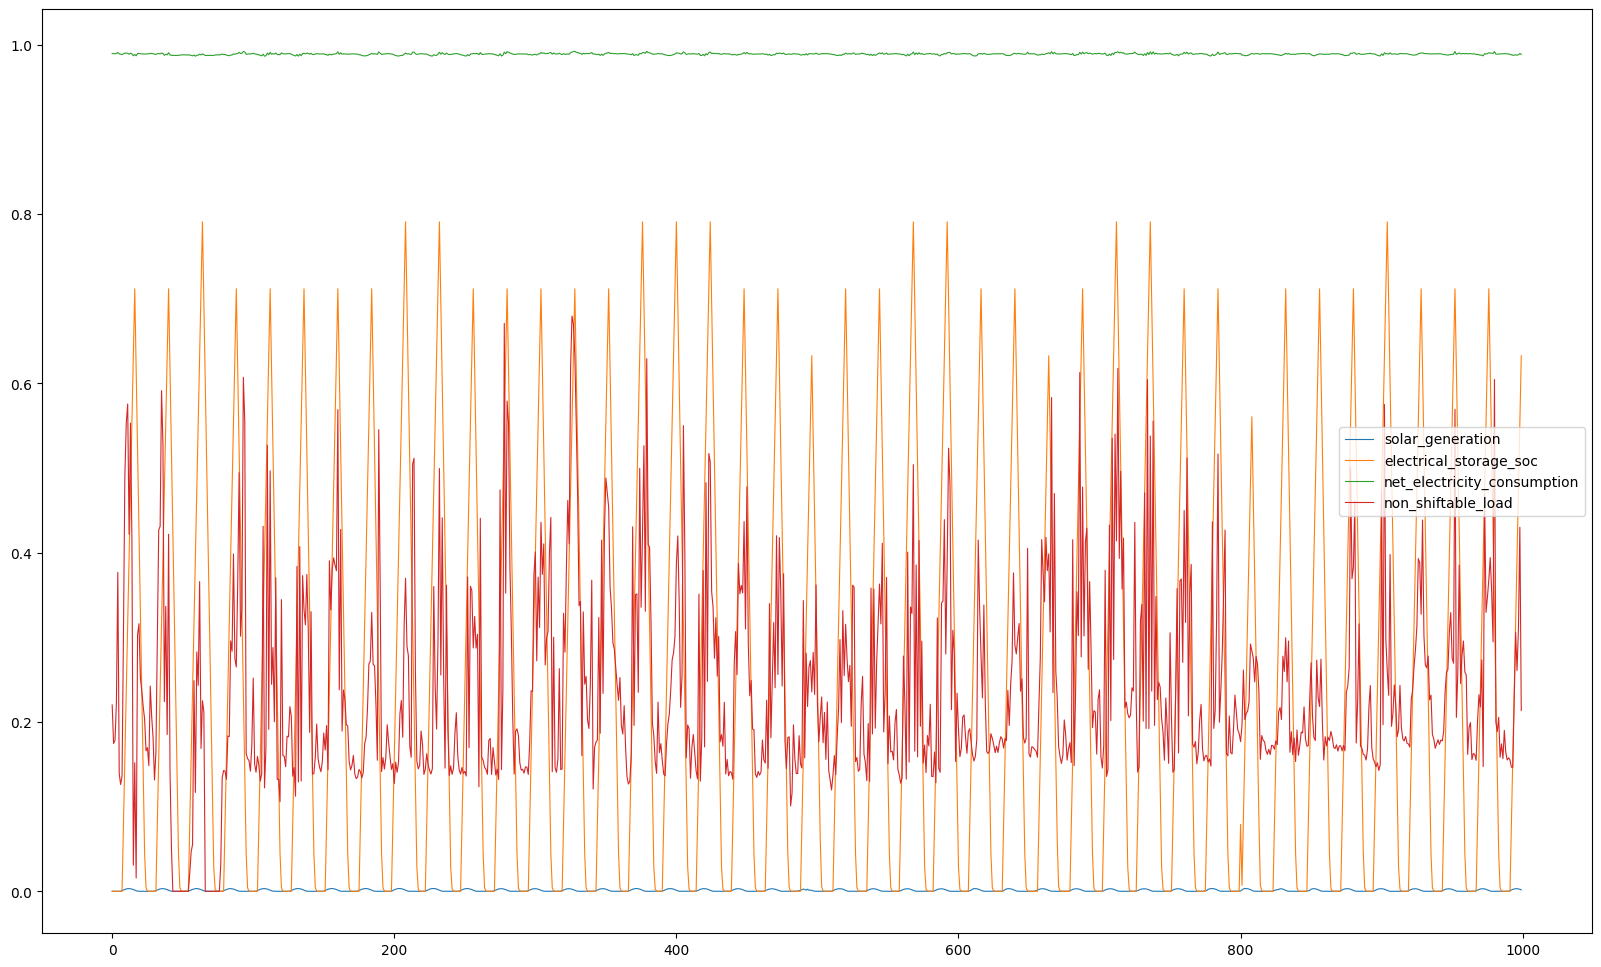

In [15]:
df_baseline_obs[[#'outdoor_dry_bulb_temperature',
                 'solar_generation',
                 'electrical_storage_soc',
                 'net_electricity_consumption',
                 'non_shiftable_load',
                 #'electricity_pricing'
                 ]][:1000].plot.line(figsize=(20,12), lw=0.8)

In [39]:
def eval_rand_attack(agent, env, eps=0.3):
    """displays the KPIs for each building and district withc random noise in the observations
    ref quickstart"""
    obs_list = []
    asr = 0

    observations = env.reset()
    
    while not env.done:
        obs_list.append(observations)
        noisey_obs = observations + np.random.rand(*observations.shape)*eps
        a_adv, _ = agent.predict(noisey_obs, deterministic=True)
        actions, _ = agent.predict(observations, deterministic=True)
        if a_adv!=actions: #check if the perturbation changed the agent's action
            asr+=1
        observations, _, _, _ = env.step(a_adv)
    obs_list.append(observations)

    asr/=env.time_steps
    print(f'The Adversarial success rate is: {asr}')
    return format_kpis(env), np.array(obs_list)

Model performance while observations are perturbed by random noise [0,1). Note that all the observation values are normalized to [0,1]

In [40]:
rand_kpis, rand_obs = eval_rand_attack(agent, env, eps=0.3)

The Adversarial success rate is: 0.42534246575342466


Here's the regret for the random attack:

In [41]:
display(baseline_kpis - rand_kpis)

cost_function
annual_peak_average                     -3.504974e-13
carbon_emissions_total                  -3.561201e-02
cost_total                              -4.168179e-02
daily_one_minus_load_factor_average      4.193267e-06
daily_peak_average                      -4.941949e-02
electricity_consumption_total           -3.855277e-02
monthly_one_minus_load_factor_average   -1.186557e-04
ramping_average                         -1.017633e-01
zero_net_energy                          8.795851e-03
Name: District, dtype: float64

In [42]:
df_rand_obs = pd.DataFrame(rand_obs, columns=index)

<Axes: >

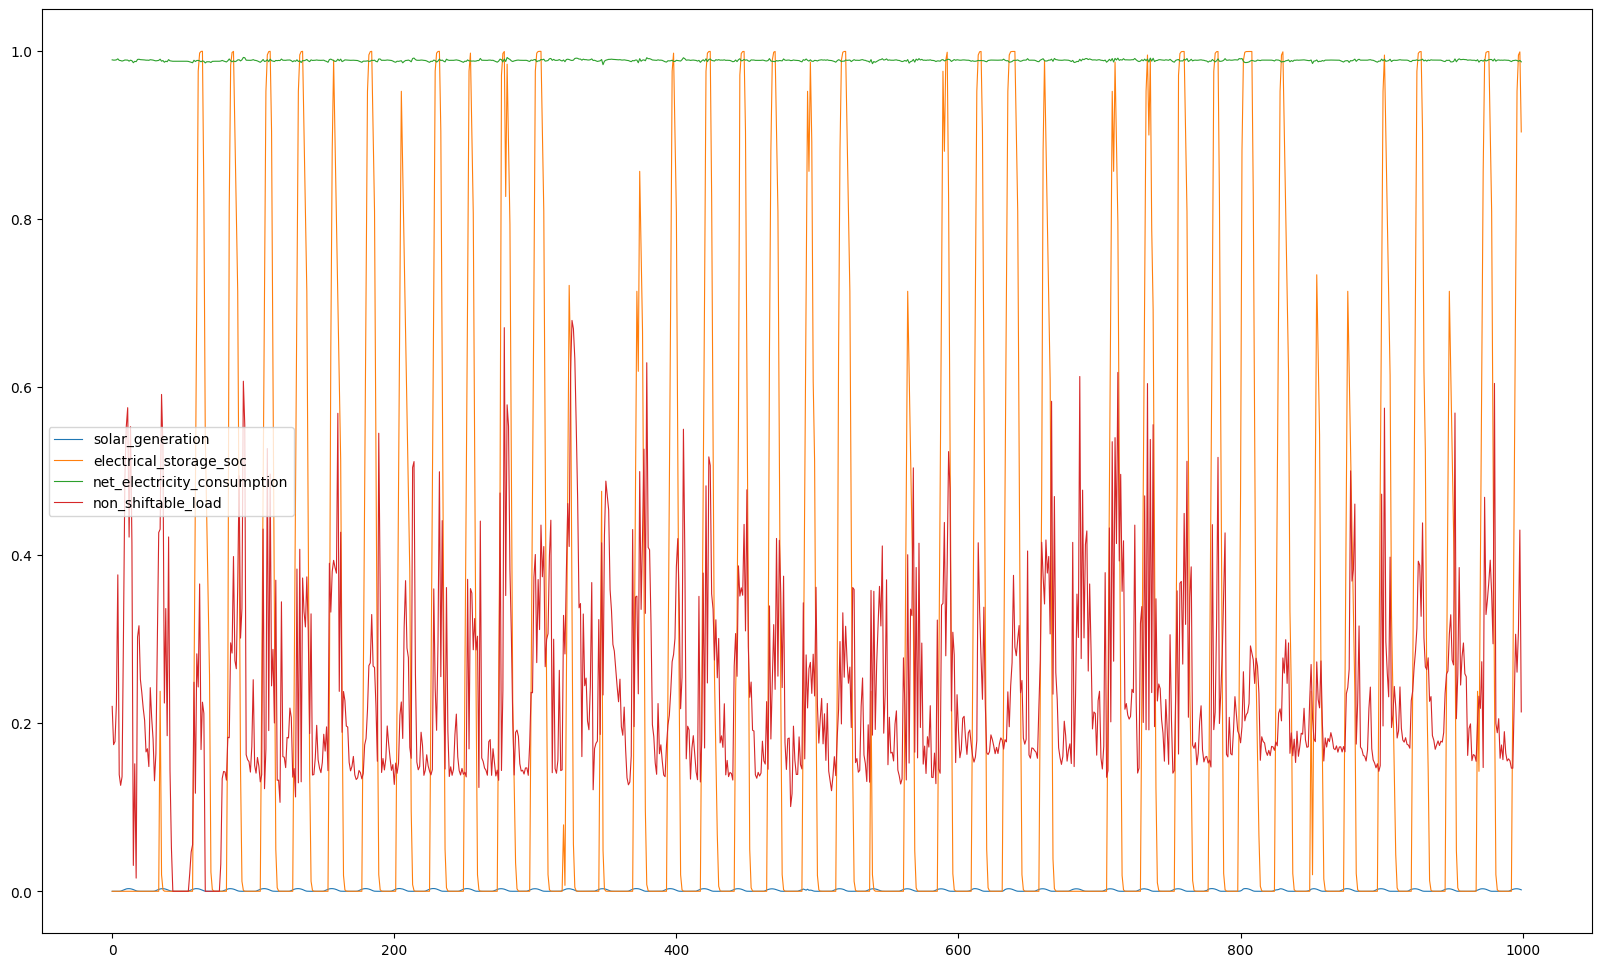

In [43]:
df_rand_obs[[#'outdoor_dry_bulb_temperature',
                 'solar_generation',
                 'electrical_storage_soc',
                 'net_electricity_consumption',
                 'non_shiftable_load',
                 #'electricity_pricing'
                 ]][:1000].plot.line(figsize=(20,12), lw=0.8)

Define our gradient based attack:

In [13]:
def extract_actor(agent):
    """Extracts the policy network from and SB3 actor critic algorithm as a pytorch seuqential network"""
    from copy import deepcopy
    policy_net = deepcopy(agent.policy.mlp_extractor.policy_net) #copies shared net rather than referencing
    policy_net.add_module('actions', agent.policy.action_net)
    return policy_net

In [14]:
def define_attack(agent, env, ART_atk, loss_fn=CrossEntropyLoss(), **kwargs):
    """returns an ART attack function based on the input gym enviornment, SB3 Agent and ART attack class"""
    
    agent_policy = extract_actor(agent)

    victim_policy = classifier(
        model=agent_policy,
        loss=loss_fn, 
        nb_classes=env.action_space[0].n,
        input_shape=agent.observation_space.shape,
        device_type='gpu'
        )

    return ART_atk(estimator=victim_policy, verbose=False, **kwargs)

In [15]:
def eval_untargeted_attack(agent, env, atk, time_steps:int=None, mask:list=None):
    """Evaluates an SB3 agent subject to untargeted observation perturbations generated by an ART evasion attack"""
    obs_list = []
    asr = 0

    observations = env.reset()
    #failed_adv_exs = 0
    if time_steps is None:
        time_steps = env.time_steps - 1
    if mask is None:
        mask=np.ones(agent.observation_space.shape[0]) #1 for all features

    for _ in tqdm(range(time_steps)):

        obs_list.append(observations)

        adv_obs = np.expand_dims(observations, axis=0) #ART atks expect a 2d array
        #would using the true label/action imporve the asr? it would hurt adversarial training: https://arxiv.org/abs/1611.01236
        adv_obs = atk.generate(adv_obs, mask=mask)
        adv_obs = np.squeeze(adv_obs) #CityLearn envs expect a 1d array
        
        a_adv, _ = agent.predict(adv_obs, deterministic=True)
        #actions, _ = agent.predict(observations, deterministic=True)
        if not np.array_equal(adv_obs, observations): #check if an adversarial example was crafted
            asr+=1
        #if a_adv!=actions: #check if the perturbation changed the agent's action
        #    asr+=1
        #elif np.array_equal(adv_obs, observations): #when the victim's action is unchanged, check if an adv observation was crafted
        #    failed_adv_exs+=1
        observations, _, _, _ = env.step(a_adv)

        if env.done:
            break
    
    obs_list.append(observations)
    asr/=time_steps
    print(f'The Adversarial success rate is: {asr}')
    #print(f'{failed_adv_exs} adversarial examples were produced but failed to change the victim\'s action')
    return format_kpis(env), np.array(obs_list)

In [16]:
ACG_parameters = dict(
    loss_type='difference_logits_ratio', 
    batch_size=1,
    eps=0.05, #default 0.3,
    eps_step=0.02, #0.1, default ration: eps:3*eps_step
    nb_random_init=5, #5, lower values speed crafting
    max_iter=100, #iterations per restart
    norm='inf', #->l2 ->l1 most restrictive 
)
attack = define_attack(agent, env, ACG, **ACG_parameters)

Before attacking the victim, we must understand what we are perturbing. So we need to see which observations/features are active in the environment (NB that periodically normalized calendar features are not properly named by the environment, so we will do it ourselves ref: https://github.com/intelligent-environments-lab/CityLearn/issues/74 ):

In [17]:
observation_masks = pd.Series(1, index=index).to_frame(name='all')

It seems that all these observations are variable (changes to constant values would indicate perturbations), however perturbations to the date and time would be obvious to an analyst. We will mask these features in our attack so they will not be perturbed.

In [18]:
observation_masks['mask_time'] = observation_masks['all']
observation_masks['mask_time'][observation_masks.index.str.contains('month|day|hour')] = 0

In [19]:
observation_masks

,all,mask_time
month_sin,1,0
month_cos,1,0
day_type_sin,1,0
day_type_cos,1,0
hour_sin,1,0
hour_cos,1,0
outdoor_dry_bulb_temperature,1,1
outdoor_dry_bulb_temperature_predicted_6h,1,1
outdoor_dry_bulb_temperature_predicted_12h,1,1
outdoor_dry_bulb_temperature_predicted_24h,1,1


Plot for preliminary results:
- outdoor_dry_bulb_temperature
- solar_generation
- electrical_storage_soc
- net_electricity_consumption
- electricity_pricing
- calculate power from grid/aggregate load

In [20]:
Adv_untargered_kpis, adv_obs = eval_untargeted_attack(agent, env, attack, time_steps=1000, mask=observation_masks['mask_time'].to_numpy())
#display(baseline_kpis - Adv_untargered_kpis)

100%|██████████| 1000/1000 [49:53<00:00,  2.99s/it] 


The Adversarial success rate is: 1.0


NameError: name 'baseline_kpis' is not defined

The adversarial regret from the untargeted adversarial attack is:

In [44]:
display(baseline_kpis - Adv_untargered_kpis)

cost_function
annual_peak_average                      0.000042
carbon_emissions_total                  -0.076540
cost_total                              -0.063261
daily_one_minus_load_factor_average      0.101663
daily_peak_average                      -0.076365
electricity_consumption_total           -0.081201
monthly_one_minus_load_factor_average    0.009951
ramping_average                         -0.194474
zero_net_energy                          0.033675
Name: District, dtype: float64

In [22]:
df_adv_obs = pd.DataFrame(adv_obs, columns=index)

<Axes: >

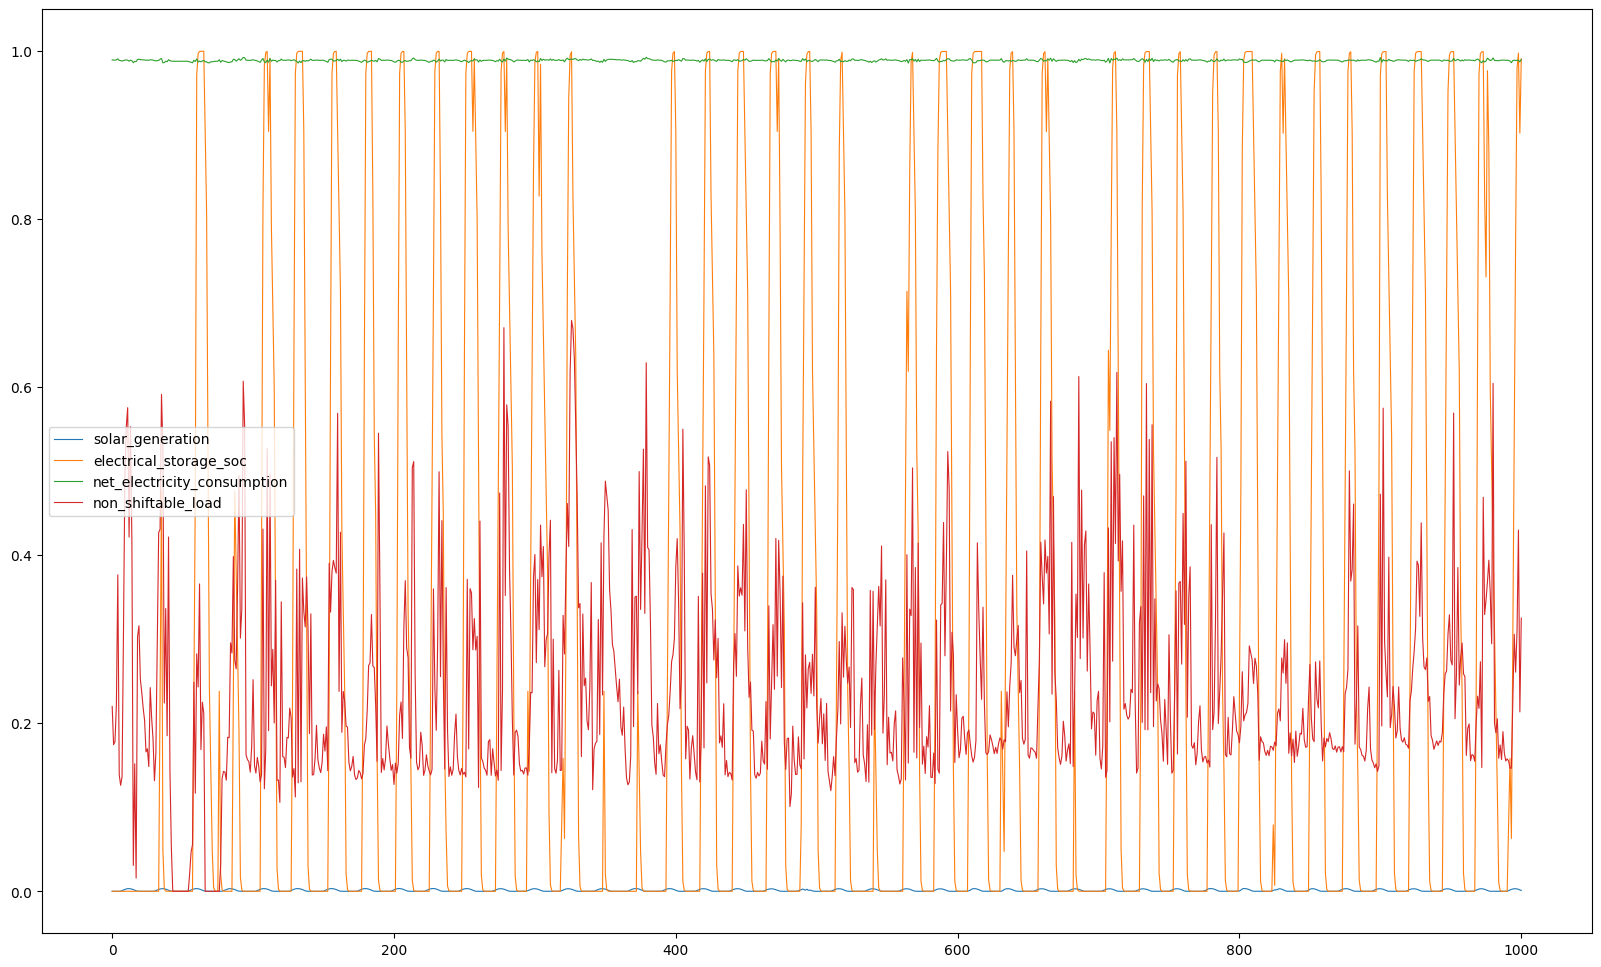

In [23]:
df_adv_obs[[#'outdoor_dry_bulb_temperature',
                 'solar_generation',
                 'electrical_storage_soc',
                 'net_electricity_consumption',
                 'non_shiftable_load',
                 #'electricity_pricing'
                 ]].plot.line(figsize=(20,12), lw=0.8)

We could mask other features where tampering would be obvious e.g. temperture predictions vary between observations, but pricing predictions are identical for many obvservations and vary predictably.

Using crossentropy: Accidentally ran this with an untrained agent, and the ASR was 0.6. This shows the attack can work and the metrics can go well over 1. ASR is 0 with trained agent. Is the victim network being copied correctly? Does the attack just need to be tuned? eps of 0.3 is already huge when the inputs are normalized in [0,1].

DLR worked better than crossentropy on the untrained agent (by accident) but works no better on the trained agent

The second metric indicated that ACG is unable to craft adv examples on the trained agent

Evaluate agent with variable epsilon:
- Start at min value and increase in loop
- try multiple values in parallel
- return stat on the eps used, box plot?